## **Exploración de archivos y librerías básicas**

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

## **Importamos librerías necesarias**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Preprocesamiento de Datos**

## **DEPRECATED: Data Augmentation avanzado MixUp**
#### > No hay mejora significativa 

#### Tras comprobar que los resultados están estabilizados y bastante bien regularizados (batch normalization, dropout, class_weight...). Añadir L2 o pequeños cambios de dropout no aporta grandes mejoras en Test. 
#### Se puede decir que el modelo:
* #### Aprende
* #### Generaliza
* #### No sobreajusta

#### Aparentemente no se trata de regularizar más, sino de hacer que el modelo vea mejores datos, o más variados y representativos. Es por eso que intentamos con una técnica de Data Augmentation mas avanzada. 
#### **MixUp:** Mezcla 2 imágenes sumándolas y promedia las etiquetas.

In [ ]:
"""
def mixup_generator(generator, alpha=0.2):
    while True:
        x, y = next(generator)
        if len(y.shape) == 1:
            y = np.expand_dims(y, axis=-1)
        batch_size = x.shape[0]
        indices = np.random.permutation(batch_size)
        x2, y2 = x[indices], y[indices]

        lam = np.random.beta(alpha, alpha, batch_size) 
        lam_x = lam.reshape(batch_size, 1, 1, 1)
        lam_y = lam.reshape(batch_size, 1)

        x_mix = x * lam_x + x2 * (1 - lam_x)
        y_mix = y * lam_y + y2 * (1 - lam_y) 

        yield x_mix, y_mix
"""

## **DEPRECATED: Carga de imágenes, etiquetado & Data Augmentation**
#### > No permite la partición aleatorizada de datos.
#### > División: 80% Train 20% Val. Keras escoge automáticamente ese 20% de imágenes y lo hace en base al orden alfabético de los archivos, no al azar.
#### > Por lo que da siempre la misma partición de datos.

#### En este punto:
* Se cargan las imágenes directamente desde carpetas, y se les asigna automáticamente una etiqueta según su clase (NORMAL o NEUMONÍA)
* Las imágenes se normalizan a valores entre 0 y 1
* Al conjunto de entrenamiento se le aplican técnicas de Data Augmentation para mejorar la generalización del modelo

#### Técnicas de Data Augmentation aplicadas (solo en entrenamiento):
* Rotación aleatoria de hasta 16 grados
* Zoom aleatorio de hasta un 10%
* Desplazamiento horizontal aleatorio del 2% del ancho
* Desplazamiento vertical aleatorio del 2% de la altura
* Inclinación (shear) de hasta 0.03 radianes
* Volteo horizontal aleatorio

#### Se ha divido el conjunto de entrenamiento, para pasar imágenes desde este conjunto al de validación, pues originalmente validación sólo contenia 16 imágenes.
#### Dejándolo en una proporción de 80/20.

In [ ]:
"""
img_size = 150
batch_size = 64

# Definición de ImageDataGenerator para entrenamiento con Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,                                         # Dividimos el contenido de train en 80/20
    rotation_range=16,         
    zoom_range=0.1,           
    width_shift_range=0.02,    
    height_shift_range=0.02,   
    shear_range=0.03,      
    horizontal_flip=True
)

# Definición de ImageDataGenerator para test sin aplicar aumentos, solo normaliza. 
test_datagen = ImageDataGenerator(rescale=1./255)

# Cargar el dataset de entrenamiento
train_generator = train_datagen.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/train',            # Cargamos las imagenes 
    target_size=(img_size, img_size),                            
    color_mode='rgb',                                            # Las imágenes originales estan en escala de grises. Esto replica el canal de grises 3 veces, para poder usar modelos preentrenados en ImageNet.
    batch_size=batch_size,                                       
    class_mode='binary',                                         # Se etiquetan automáticamente como 0 o 1
    subset='training',                                           # Toma el 80% de las imágenes. Y aplica data augmentations
    shuffle=True                                                 # Las imágenes se mezclan aleatoriamente
)

# Cargar el dataset de validación
val_generator = train_datagen.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/train',            # Se usa la misma carpeta train (y train_datagen)
    target_size=(img_size, img_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',                                         # Se extrae el otro 20%. Keras desactiva automáticamente todos los augmentations
    shuffle=False                                                # No aplica
)

# Cargar el dataset de test
test_generator = test_datagen.flow_from_directory(
    '../input/chest-xray-pneumonia/chest_xray/test',
    target_size=(img_size, img_size),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# train_mixup_generator = mixup_generator(train_generator, alpha=0.15)
"""

#### Dataset original:
* #### Entrenamiento -> 5216 imágenes
* #### Validación -> 16 imágenes
* #### Test -> 624 imágenes

#### Partiendo el conjunto de Entrenamiento en 80/20 para darle mas imágenes a Validación (despreciando las 16 imágenes que contenia), queda finalmente:
* #### Entrenamiento -> 4173 imágenes
* #### Validación -> 1043 imágenes
* #### Test -> 624 imágenes

## **Carga de imágenes, etiquetado & Data Augmentation V2**

In [4]:
# ======================
# RUTAS AL DATASET
# ======================
train_dir = '../input/chest-xray-pneumonia/chest_xray/train'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val'

# ============================
# CARGAR IMÁGENES Y ETIQUETAS
# ============================
def get_image_paths_labels(data_dir):
    categories = ['NORMAL', 'PNEUMONIA']
    image_paths = []
    labels = []
    
    for category in categories:
        folder_path = os.path.join(data_dir, category)
        for img in os.listdir(folder_path):
            if img.lower().endswith(('.jpg', '.jpeg')):
                image_paths.append(os.path.join(folder_path, img))
                labels.append(category)
    
    return image_paths, labels

In [6]:
# ======================
# DATAFRAMES PARA TEST
# ======================
test_paths, test_labels = get_image_paths_labels(test_dir)
test_df = pd.DataFrame({'filename': test_paths, 'label': test_labels})

# =======================
# DATAFRAMES Y PARTICIÓN
# =======================
def get_dataframes(train_dir, val_dir, seed=0):
    train_paths, train_labels = get_image_paths_labels(train_dir)
    val_paths, val_labels = get_image_paths_labels(val_dir)

    # Unimos train + val
    all_paths = train_paths + val_paths
    all_labels = train_labels + val_labels
    
    df = pd.DataFrame({'filename': all_paths, 'label': all_labels})

    # Split 80/20
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=seed)

    return train_df, val_df

In [7]:
# ================================
# DATA AUGMENTATION Y GENERADORES
# ================================
def get_data_generators(train_df, val_df, test_df, img_size=150, batch_size=64, seed=0):
    # Data Augmentation 
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        zoom_range=0.1,
        width_shift_range=0.04,
        height_shift_range=0.04,
        brightness_range=(0.9, 1.1),
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=None, 
        x_col='filename',
        y_col='label',
        target_size=(img_size, img_size),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=seed
    )

    val_generator = val_test_datagen.flow_from_dataframe(
        val_df,
        directory=None, 
        x_col='filename',
        y_col='label',
        target_size=(img_size, img_size),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_dataframe(
        test_df,
        directory=None, 
        x_col='filename',
        y_col='label',
        target_size=(img_size, img_size),
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )  
    
    return train_generator, val_generator, test_generator

In [8]:
train_df, val_df = get_dataframes(train_dir, val_dir, seed=0)
train_generator, val_generator, test_generator = get_data_generators(train_df, val_df, test_df, img_size=150, batch_size=64, seed=0)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


#### Dataset original:
* #### Entrenamiento -> 5216 imágenes
* #### Validación -> 16 imágenes
* #### Test -> 624 imágenes
#### Total = 5856 imágenes

#### Hemos juntado Entrenamiento y Validación, para después dividirlo en la proporción: 80% y 20% respectivamente. De este modo no hemos perdido niguna imagen del dataset.
* #### Entrenamiento -> 4185 imágenes
* #### Validación -> 1047 imágenes
* #### Test -> 624 imágenes
#### Total = 5856 imágenes

#### Aplicar Data Augmentation no aumenta el numero total de imágenes del dataset en disco, sino que las modifica "al vuelo" cada vez que se entrena el modelo, es decir, en memoria.
#### Una imagen puede ser rotada en la primera época, y en la segunda época esa misma imagen aplicar un desplazamiento, o zoom.

#### Por lo tanto, podemos estimar el numero de imágenes que el modelo ve (recordemos que son variaciones distintas de una misma imagen) segun el número de épocas que hayamos definido.

In [9]:
n_original = len(train_generator.filenames)
print(f"Número de imágenes originales: {n_original}")

n_epochs = 25
print(f"Imágenes vistas por el modelo durante {n_epochs} épocas (estimación): {n_epochs * n_original}")

Número de imágenes originales: 4185
Imágenes vistas por el modelo durante 25 épocas (estimación): 104625


## **Previsualización de imágenes**

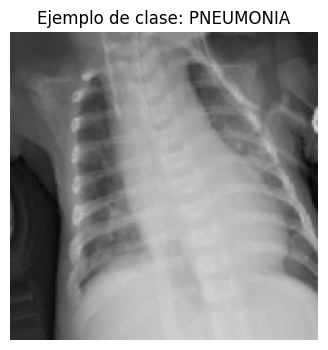

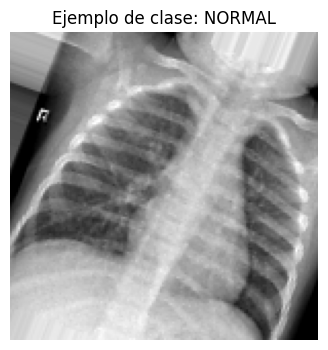

In [11]:
label_map = {v: k for k, v in train_generator.class_indices.items()}
images, labels = next(train_generator)
shown_classes = set()

for i in range(len(images)):
    class_label = int(labels[i])
    if class_label not in shown_classes:
        plt.figure(figsize=(4, 4))
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Ejemplo de clase: {label_map[class_label]}")
        plt.axis('off')
        plt.show()
        shown_classes.add(class_label)
    if len(shown_classes) == 2:
        break

## **Muestreo de cada clase**
#### > Nos centramos en analizar el **conjunto de Entrenamiento**, pues es donde el modelo aprende. Si hay un desbalanceo aqui, el modelo puede aprender un sesgo hacia la clase mayoritaria.
#### > **Validación y Test** se usan tal y como están, sin balancear. El objetivo es evaluar la capacidad real del modelo en un entorno natural, donde los datos pueden venir desbalanceados.

#### Como se puede observar en la gráfica, el conjunto de datos de Entrenamiento está desbalanceado: hay muchas más imágenes de **neumonía** que de **normal**.
#### El uso de **Data Augmentation** ayuda a reducir el sobreajuste (overfitting), favoreciendo el aprendizaje de patrones más robustos y generalizables.
#### Sin embargo, en este caso se ha aplicado por igual a ambas clases, lo que no corrige el desbalanceo, sino que mantiene el sesgo hacia la clase mayoritaria (neumonía), facilitando que el modelo tienda a predecirla con mayor frecuencia.
#### Alternativas comunes para abordar este desbalanceo:
* #### Aplicar data augmentation solo sobre la clase minoritaria (normal).
* #### Utilizar el parámetro *class_weight* durante el entrenamiento para dar más importancia a la clase menos representada.

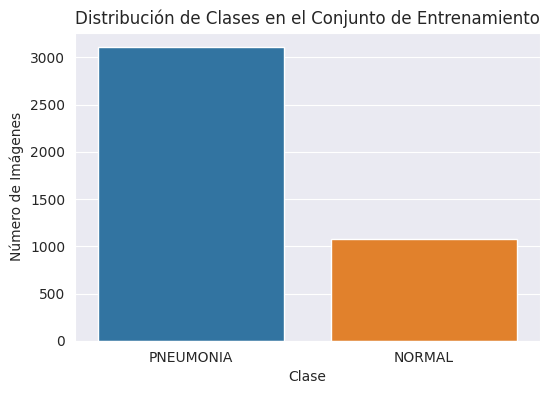

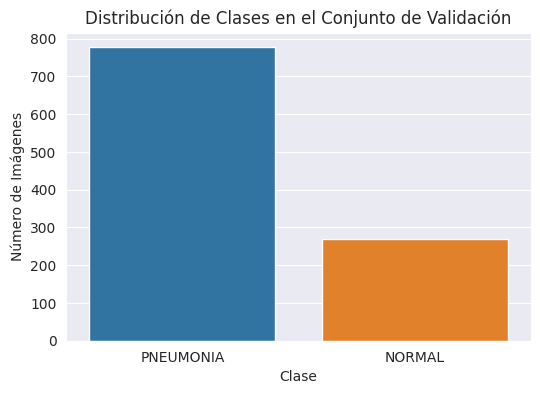

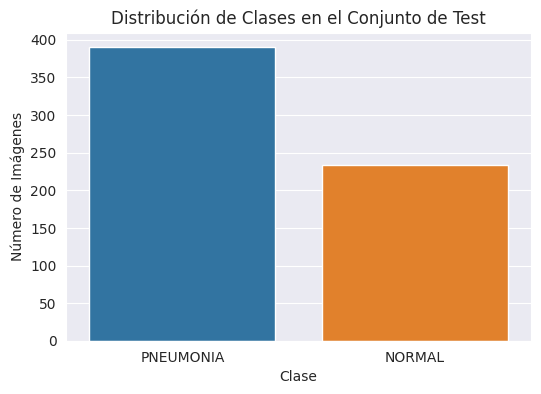

In [12]:
def class_distribution(generator, title):
    labels = generator.classes
    label_map = {v: k for k, v in generator.class_indices.items()}
    label_names = [label_map[i] for i in labels]
    label_names = pd.Categorical(label_names, categories=['PNEUMONIA', 'NORMAL'], ordered=True)

    sns.set_style("darkgrid")
    plt.figure(figsize=(6, 4))
    sns.countplot(x=pd.Series(label_names))
    plt.title(title)
    plt.xlabel("Clase")
    plt.ylabel("Número de Imágenes")
    plt.show()

class_distribution(train_generator, "Distribución de Clases en el Conjunto de Entrenamiento")
class_distribution(val_generator, "Distribución de Clases en el Conjunto de Validación")
class_distribution(test_generator, "Distribución de Clases en el Conjunto de Test")

## **Ajuste al desbalanceo de clases**

#### Hemos aplicado ***class_weight*** para compensar el desequilibrio entre clases durante el entrenamiento de forma sencilla y efectiva.
#### Que hemos conseguido:
* #### Penalizamos más los errores en la clase minoritaria (**NORMAL**).
* #### Mejora el **recall** (sensibilidad) para dicha clase.
* #### Ayuda a evitar un sesgo hacia la clase mayoritaria (**PNEUMONIA**).
* #### El ajuste se aplica directamente en la función de pérdida, sin alterar los datos de entrada.

#### Los pesos se calculan automáticamente con **balanced**, que aplica: *class_weight = N_total / (N_clase * N_clases)*

In [11]:
def get_class_weights(train_df):
    y_train = train_df['label']
    classes = np.unique(y_train)
    
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))
    return class_weights

class_weights = get_class_weights(train_df)
print("Pesos de las clases:", class_weights)

Pesos de las clases: {'NORMAL': 1.9392956441149212, 'PNEUMONIA': 0.6736960721184804}


# **Callbacks Globales para el Entrenamiento**

In [12]:
def get_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_auc',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )

    reduce_learning_rate = ReduceLROnPlateau(
        monitor='val_auc',
        patience=2,
        factor=0.3,
        min_lr=1e-5,
        mode='max',
        verbose=1
    )

    return [early_stopping, reduce_learning_rate]

callbacks = get_callbacks()
print("Callbacks usados:")
for callback in callbacks:
    print(" -", type(callback).__name__)

Callbacks usados:
 - EarlyStopping
 - ReduceLROnPlateau


# **Entrenamiento Desde Cero**

## **Entrenamiento del Modelo 1: Custom CNN**

### Arquitectura

In [18]:
def build_custom_cnn(img_size=150, learning_rate=0.0005):
    model = Sequential([
        Input(shape=(img_size, img_size, 3)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy', AUC(name='auc')]
    )

    return model
    
model_cnn = build_custom_cnn()
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 150, 150, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 37, 37, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,596,577 (21.35 MB)

 Trainable params: 5,596,129 (21.35 MB)

 Non-trainable params: 448 (1.75 KB)

1. **Output Shape:** tamaño del tensor de salida (número de características o mapas de activación que salen de cada capa)
2. **Param #:** Cantidad de parámetros entrenables en cada capa (es decir, los pesos que el modelo aprende)
    1. **En capas Conv2D:** (kernel_height × kernel_width × input_channels × output_filters) + output_filters || Ejemplo: 3 × 3 × 3 × 32 + 32 = 896
    2. **En capas Dense:** (input_neurons × output_neurons) + output_neurons || Ejemplo: 41.472 × 128 + 128 = 5.308.544

### Entrenamiento


=== SEMILLA 0 ===
Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1754743836.744010    6339 service.cc:148] XLA service 0x7b5c0c007360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754743836.744054    6339 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754743836.744061    6339 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754743837.304325    6339 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/66 ━━━━━━━━━━━━━━━━━━━━ 22:37 21s/step - accuracy: 0.6406 - auc: 0.6000 - loss: 0.8108

I0000 00:00:1754743851.241001    6339 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.6776 - auc: 0.6006 - loss: 2.7604 - val_accuracy: 0.7421 - val_auc: 0.6712 - val_loss: 0.8989 - learning_rate: 5.0000e-04
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 949ms/step - accuracy: 0.8513 - auc: 0.9285 - loss: 0.2958 - val_accuracy: 0.7421 - val_auc: 0.5102 - val_loss: 1.2341 - learning_rate: 5.0000e-04
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.8970 - auc: 0.9503 - loss: 0.2460
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 947ms/step - accuracy: 0.8970 - auc: 0.9503 - loss: 0.2460 - val_accuracy: 0.7421 - val_auc: 0.4981 - val_loss: 1.7945 - learning_rate: 5.0000e-04
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 944ms/step - accuracy: 0.9144 - auc: 0.9632 - loss: 0.2264 - val_accuracy: 0.7421 - val_auc: 0.5000 - val_loss: 2.9154 - learning_rate: 1.5000e-04
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.9377 - auc: 0.9722 - loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6952 - auc: 0.6234 - loss: 2.2776 - val_accuracy: 0.7421 - val_auc: 0.8411 - val_loss: 0.7376 - learning_rate: 5.0000e-04
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 943ms/step - accuracy: 0.8160 - auc: 0.9110 - loss: 0.3234 - val_accuracy: 0.7421 - val_auc: 0.5131 - val_loss: 1.2059 - learning_rate: 5.0000e-04
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.8907 - auc: 0.9466 - loss: 0.2460
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 929ms/step - accuracy: 0.8906 - auc: 0.9466 - loss: 0.2462 - val_accuracy: 0.7421 - val_auc: 0.5509 - val_loss: 1.3574 - learning_rate: 5.0000e-04
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 932ms/step - accuracy: 0.8938 - auc: 0.9501 - loss: 0.2499 - val_accuracy: 0.7421 - val_auc: 0.4870 - val_loss: 1.5552 - learning_rate: 1.5000e-04
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.9089 - auc: 0.96

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6690 - auc: 0.5908 - loss: 3.3893 - val_accuracy: 0.7421 - val_auc: 0.9318 - val_loss: 0.7158 - learning_rate: 5.0000e-04
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 944ms/step - accuracy: 0.7304 - auc: 0.8588 - loss: 0.4032 - val_accuracy: 0.7421 - val_auc: 0.7649 - val_loss: 1.3297 - learning_rate: 5.0000e-04
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.8270 - auc: 0.8820 - loss: 0.3555
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 947ms/step - accuracy: 0.8270 - auc: 0.8820 - loss: 0.3553 - val_accuracy: 0.7421 - val_auc: 0.5000 - val_loss: 1.7631 - learning_rate: 5.0000e-04
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 941ms/step - accuracy: 0.8447 - auc: 0.8963 - loss: 0.3279 - val_accuracy: 0.7421 - val_auc: 0.5000 - val_loss: 2.0078 - learning_rate: 1.5000e-04
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.8585 - auc: 0.90

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7520 - auc: 0.7255 - loss: 1.8424 - val_accuracy: 0.7421 - val_auc: 0.9188 - val_loss: 0.8176 - learning_rate: 5.0000e-04
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 939ms/step - accuracy: 0.8959 - auc: 0.9533 - loss: 0.2409 - val_accuracy: 0.7421 - val_auc: 0.8414 - val_loss: 1.0262 - learning_rate: 5.0000e-04
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.9106 - auc: 0.9634 - loss: 0.2154
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 974ms/step - accuracy: 0.9106 - auc: 0.9633 - loss: 0.2155 - val_accuracy: 0.7421 - val_auc: 0.5000 - val_loss: 2.0207 - learning_rate: 5.0000e-04
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 949ms/step - accuracy: 0.9230 - auc: 0.9688 - loss: 0.1995 - val_accuracy: 0.7421 - val_auc: 0.5000 - val_loss: 2.8045 - learning_rate: 1.5000e-04
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.9338 - auc: 0.97

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.6674 - auc: 0.5917 - loss: 2.4989 - val_accuracy: 0.7421 - val_auc: 0.9623 - val_loss: 0.5777 - learning_rate: 5.0000e-04
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 945ms/step - accuracy: 0.7681 - auc: 0.8694 - loss: 0.3658 - val_accuracy: 0.7421 - val_auc: 0.7377 - val_loss: 1.2074 - learning_rate: 5.0000e-04
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.8119 - auc: 0.9115 - loss: 0.3244
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 937ms/step - accuracy: 0.8122 - auc: 0.9115 - loss: 0.3243 - val_accuracy: 0.7421 - val_auc: 0.5000 - val_loss: 2.0129 - learning_rate: 5.0000e-04
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 936ms/step - accuracy: 0.8503 - auc: 0.9226 - loss: 0.2979 - val_accuracy: 0.7421 - val_auc: 0.5000 - val_loss: 2.1217 - learning_rate: 1.5000e-04
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.8745 - auc: 0.93

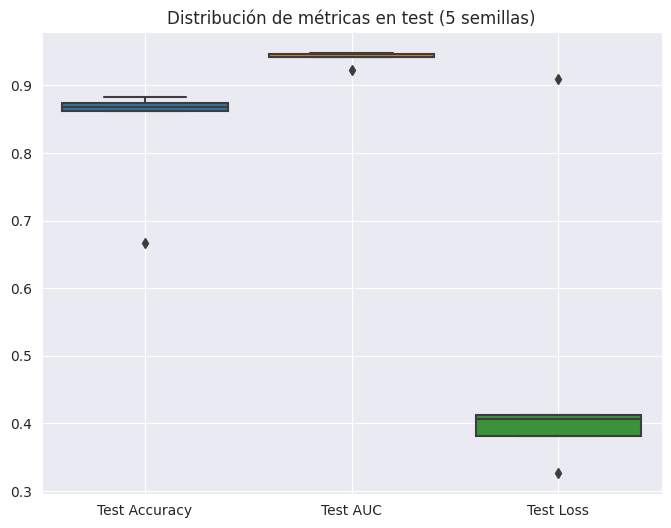

In [19]:
img_size = 150
batch_size = 64
learning_rate=0.0005
seeds = [0, 1, 2, 3, 4]

results_list = []
histories = {}
models = {}

test_paths, test_labels = get_image_paths_labels(test_dir)
test_df = pd.DataFrame({'filename': test_paths, 'label': test_labels})

for seed in seeds:
    print(f"\n=== SEMILLA {seed} ===")

    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Preparar datos
    train_df, val_df = get_dataframes(train_dir, val_dir, seed)
    train_generator, val_generator, test_generator = get_data_generators(train_df, val_df, test_df, img_size, batch_size, seed)
    
    # Ajuste de pesos
    class_weights = get_class_weights(train_df)
    
    # Crear modelo Custom CNN
    model_cnn = build_custom_cnn(img_size, learning_rate)
    
    # Callbacks
    callbacks = get_callbacks()
    
    # Entrenamiento
    history = model_cnn.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        class_weight=class_weights,
        callbacks=callbacks,
    )
    
    histories[seed] = history
    models[seed] = model_cnn
    
    # Evaluación en test
    results = model_cnn.evaluate(test_generator, verbose=0)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"AUC: {results[2]:.4f}")
    
    # Guardar resultados
    results_list.append({
        'Seed': seed,
        'Test Loss': results[0],
        'Test Accuracy': results[1],
        'Test AUC': results[2]
    })

# Mostramos resultados
df_results = pd.DataFrame(results_list)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_results[['Test Accuracy', 'Test AUC', 'Test Loss']])
plt.title('Distribución de métricas en test (5 semillas)')
plt.grid(True)
plt.show()

#### Estas métricas nos permiten evaluar si el modelo está aprendiendo correctamente o si está cayendo en problemas como el sobreajuste. 
* **Accuracy (entrenamiento):** Mide el porcentaje de aciertos del modelo sobre los datos de entrenamiento.
* **Accuracy (validación):** Refleja la precisión sobre datos nunca vistos durante el entrenamiento.
* **Loss (entrenamiento):** Es la función de pérdida que el modelo intenta minimizar.
* **Loss (validación):** Igual que la de entrenamiento, pero en validación.
* **AUC:** Esta métrica mide la capacidad del modelo para diferenciar entre clases. Valores cercanos a 1.0 indican una excelente discriminación.
* **Reducción de Learning Rate + Early Stopping:** Se han utilizado callbacks para detener el entrenamiento (EarlyStopping) cuando la métrica de validación deja de mejorar después de un número determinado de épocas (patience). Y para reducir la tasa de aprendizaje (ReduceLROnPlateau) cuando la métrica monitorizada (val_auc) se estanca. Esto ayuda a que el optimizador realice ajustes más finos, mejorando la convergencia sin provocar grandes oscilaciones.

## **Análisis Después del Entrenamiento**

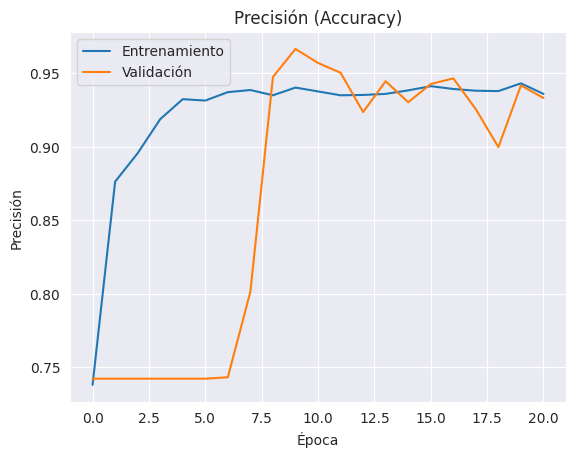

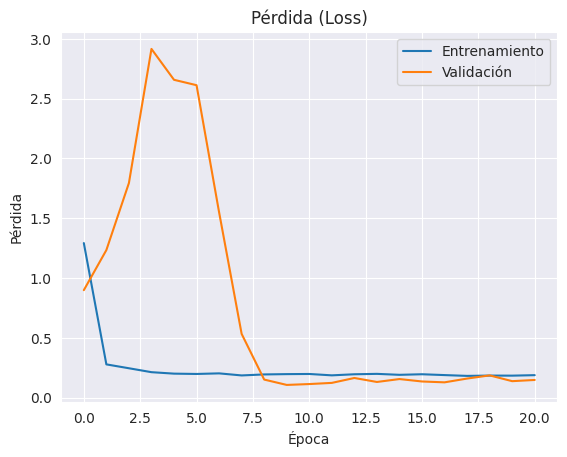

In [20]:
# Elegimos semilla
history = histories[0] 

# Accuracy
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

* **Precisión (Accuracy)**
    * En las primeras épocas, la precisión en validación permanece estancada mientras el modelo empieza a aprender patrones básicos.
    * Posteriormente, la curva de validación se eleva bruscamente, lo que indica que el modelo comienza a generalizar y acertar en imágenes no vistas.
    * Es curioso cuando la precisión en validación supera a la de entrenamiento: el conjunto de validación es más "fácil" porque no contiene Data Augmentation, a diferencia del entrenamiento que sí incluye aumentos (rotaciones, desplazamientos, etc.), haciendo las imágenes más difíciles de aprender.

* **Pérdida (Loss)** 
    * La pérdida disminuye de forma consistente tanto en entrenamiento como en validación, lo cual es una buena señal.
    * Indica que el modelo no solo acierta más, sino que comete errores menos graves (predice con mayor confianza).

## **Evaluación del Rendimiento Custom**

In [7]:
def evaluar_modelo(modelo, test_generator, nombre_modelo="Modelo"):
    test_generator.shuffle = False
    test_generator.reset()
    
    y_pred_probs = modelo.predict(test_generator)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    y_true = test_generator.classes

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=test_generator.class_indices.keys(),yticklabels=test_generator.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas de Clasificación
    print(f"\nMétricas de Clasificación - {nombre_modelo}")
    print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

    # AUC-ROC y Especificidad
    auc = roc_auc_score(y_true, y_pred_probs)
    print(f"AUC-ROC: {auc:.4f}")
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    print(f"Especificidad: {specificity:.4f}")

    return y_true, y_pred, y_pred_probs

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 409ms/step


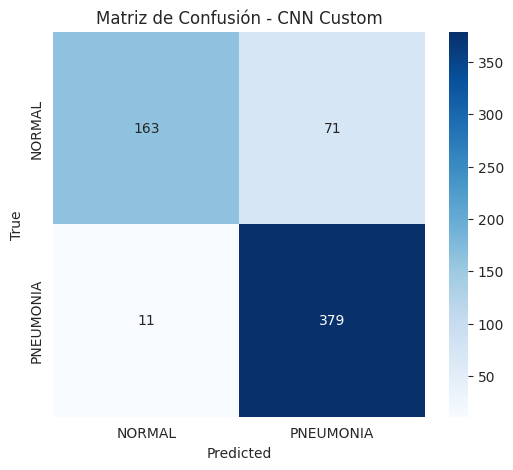


Métricas de Clasificación - CNN Custom
              precision    recall  f1-score   support

      NORMAL       0.94      0.70      0.80       234
   PNEUMONIA       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624

AUC-ROC: 0.9524
Especificidad: 0.6966


In [28]:
# Elegimos la semilla para ver las métricas de esa ejecución
y_true, y_pred, y_pred_probs = evaluar_modelo(models[0], test_generator, nombre_modelo="CNN Custom")

#### **Matriz de Confusión:**
#### Nos permite observar el rendimiento del modelo clasificando correctamente las imágenes en ambas clases: NORMAL y PNEUMONIA. 
* #### Clasifica correctamente la mayoría de los casos de **PNEUMONIA**: 379 de 390
* #### En la clase **NORMAL** clasifica correctamente: 163 de 234. Hay mas errores, lo que reduce la **especificidad**.
#### Esto es común en datasets médicos, donde suele ser más grave fallar en un positivo (falso negativo) que en un falso positivo.

#### **Métricas de Clasificación:**
#### **1. Precisión**
* #### NORMAL ->  0.94. El 94% de las veces que el modelo predice que es normal, acierta.
* #### PNEUMONIA ->  0.84. El 84% de las veces que predice neumonía, acierta.

#### **2. Recall (Sensibilidad)**
* #### NORMAL -> 0.70. Tiene más dificultades detectando correctamente imágenes sin neumonía (más falsos positivos).
* #### PNEUMONIA ->  0.97. El modelo detecta correctamente el 97% de los casos enfermos (muy relevante en diagnóstico médico).

#### **3. F1-Score**
* #### Buen equilibrio entre precisión y recall, especialmente alto en la clase neumonía (0.90), lo que refuerza su utilidad como modelo de ayuda diagnóstica.

#### **4. Accuracy** -> 0.87
* #### Precisión global del modelo. Es un buen valor, pero puede ser engañoso si el dataset está desbalanceado.

#### **AUC-ROC (0.9524):** 
* #### Indica excelente capacidad del modelo para distinguir entre ambas clases. Cuanto más cerca de 1, mejor.

#### **Especificidad (0.6966):** 
* #### Mide la capacidad del modelo para identificar correctamente los casos normales. Es sensiblemente inferior al recall de neumonía, lo que sugiere un sesgo del modelo hacia la detección de neumonía. Esto podría estar relacionado con un desbalanceo leve o con un patrón más claro en los casos positivos que en los negativos.

## **Conjunto Test: Ejemplos clasificados correctamente**

#### En este y el siguiente apartado, analizamos visualmente las imágenes bien clasificadas, y especialmente las mal clasificadas (falsos positivos y falsos negativos), para entender si el error es comprensible incluso para un humano (ruido, baja calidad, mal etiquetado, etc.).

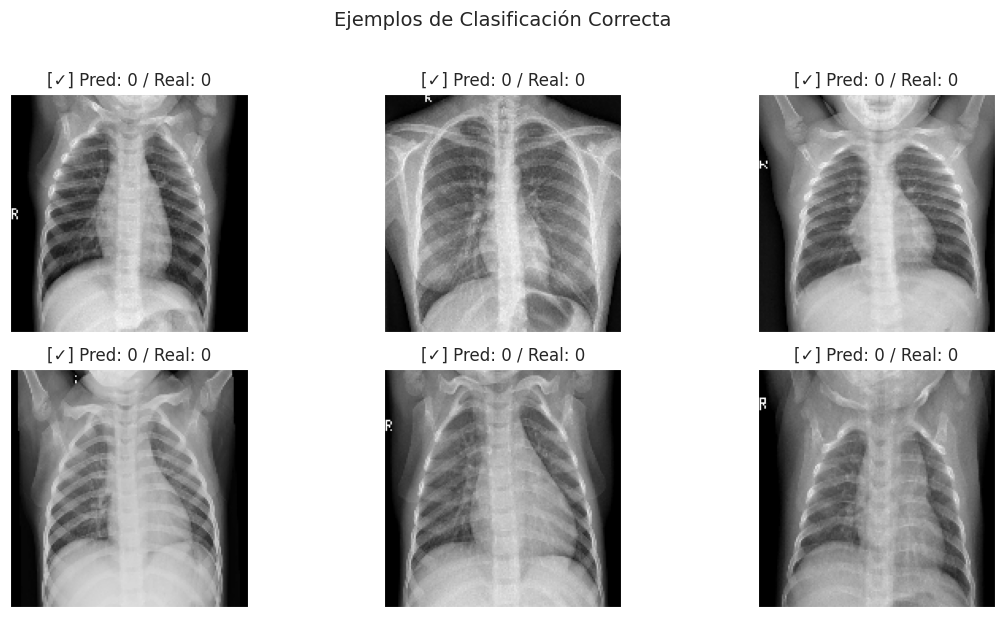

In [29]:
test_generator.reset()

x_imgs = []
for i in range(len(test_generator)):
    batch_imgs, _ = test_generator[i]
    x_imgs.extend(batch_imgs)
x_imgs = np.array(x_imgs)

correct = [i for i in range(len(y_pred)) if y_pred[i] == y_true[i]]

plt.figure(figsize=(12, 6))
for i, c in enumerate(correct[:6]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_imgs[c], cmap='gray')
    plt.title(f"[✓] Pred: {y_pred[c]} / Real: {y_true[c]}")
    plt.xticks([]), plt.yticks([])
plt.suptitle("Ejemplos de Clasificación Correcta", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## **Conjunto Test: Ejemplos clasificados incorrectamente**

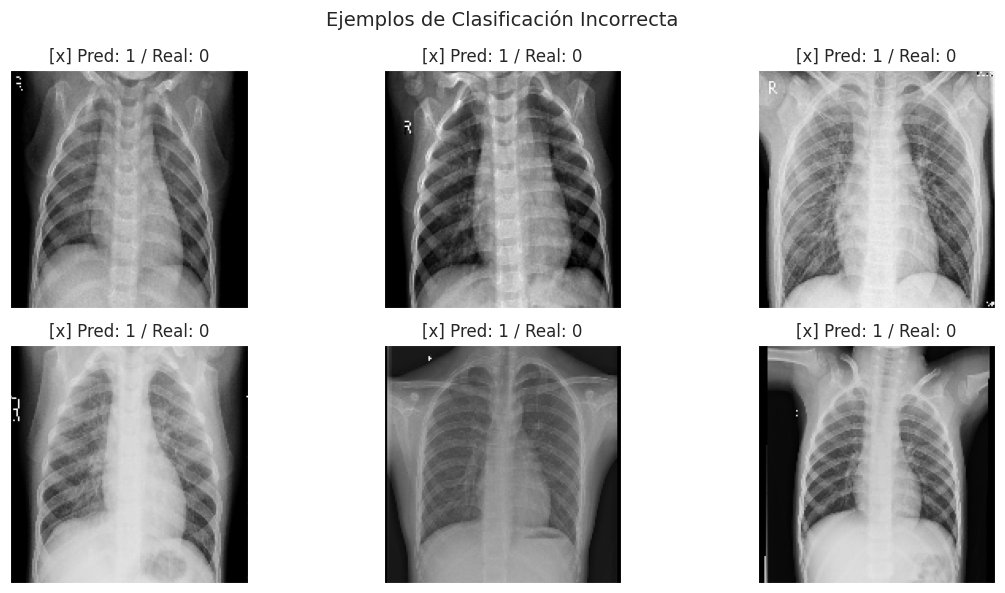

In [30]:
test_generator.reset()

x_imgs = []
for i in range(len(test_generator)):
    batch_imgs, _ = test_generator[i]
    x_imgs.extend(batch_imgs)
x_imgs = np.array(x_imgs)

incorrect = [i for i in range(len(y_pred)) if y_pred[i] != y_true[i]]

plt.figure(figsize=(12, 6))
for i, c in enumerate(incorrect[:6]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_imgs[c], cmap='gray')
    plt.title(f"[x] Pred: {y_pred[c]} / Real: {y_true[c]}")
    plt.xticks([]), plt.yticks([])
plt.suptitle("Ejemplos de Clasificación Incorrecta", fontsize=14)
plt.tight_layout()
plt.show()


# **Transfer Learning**

In [15]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import backend as K

#### En este segundo enfoque, denominado Transfer Learning (aprendizaje por transferencia), consiste en utilizar un modelo preentrenado como extractor de características. Se seleccionarán DenseNet121 y ResNet50, ambos disponibles en el paquete Keras.

#### Estos modelos ya se entrenaron en otro conjunto de datos (ImageNet). Lo que se hará aquí es establecer **include_top=False**, es decir, quitamos el clasificador final del modelo original de ImageNet, responsable de asignar las clases para el conjunto de datos, y nos quedamos solo con las capas convolucionales que extraen las características.

#### Más adelante que aplicará fine-tuning, para lo cual es necesario descongelar los pesos de algunas capas convolucionales ya entrenadas. Estableceremos **layer.trainable = True**

#### Finalmente añadir que existen versiones de DenseNet y ResNet con una precisión esperada algo mejor, tales como: DenseNet201 o ResNet152 pero con una velocidad algo mas lenta, muchos mas millones de parámetros, etc. El motivo de descartarlas ha sido principalmente por la velocidad y tiempo, al necesitar GPU muy potentes.

## **Entrenamiento del Modelo 2: DenseNet121**

## **Feature Extraction D**

### **Modelo base**
#### Hemos cargado el modelo base DenseNet121 con pesos preentrenados en ImageNet, excluyendo su capa de clasificación (include_top=False). Todas las capas se han congelado (trainable=False), por lo que en esta etapa ningún peso se actualizará durante el entrenamiento.

### **Top model**
#### Hemos añadido nuestro propio clasificador al final del modelo base, compuesto por capas densas adaptadas al problema binario (sigmoid). Solo los pesos de esta nueva "cabeza" se entrenan, mientras que las capas convolucionales preentrenadas permanecen congeladas.

#### Esto se conoce como feature extraction, ya que reutilizamos las características previamente aprendidas por el modelo (en ImageNet) y solo entrenamos la parte final con nuestro conjunto de datos.

In [16]:
def build_densenet_model(img_size=150):
    # Modelo base
    base_model_densenet = DenseNet121(weights='imagenet',include_top=False,input_shape=(img_size, img_size, 3))
    base_model_densenet.trainable = False

    # Top model
    x = base_model_densenet.output
    x = GlobalAveragePooling2D()(x)             
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model_densenet = Model(inputs=base_model_densenet.input, outputs=output)
    model_densenet.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model_densenet

model_densenet = build_densenet_model()
model_densenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 156, 156, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 38, 38, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 38, 38, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 38, 38, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 133,377 (521.00 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

**Resumen arquitectura:**

Total params: 7,172,929 (27.36 MB)

Trainable params: 133,377 (521.00 KB)

Non-trainable params: 7,039,552 (26.85 MB)


=== SEMILLA 0 ===
Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.7350 - auc: 0.8324 - loss: 0.5127 - val_accuracy: 0.8567 - val_auc: 0.9672 - val_loss: 0.3683 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9008 - auc: 0.9554 - loss: 0.2328 - val_accuracy: 0.9064 - val_auc: 0.9778 - val_loss: 0.2401 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9099 - auc: 0.9600 - loss: 0.2188 - val_accuracy: 0.9408 - val_auc: 0.9818 - val_loss: 0.1785 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9045 - auc: 0.9578 - loss: 0.2294 - val_accuracy: 0.9312 - val_auc: 0.9824 - val_loss: 0.1876 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9143 - auc: 0.9659 - loss: 0.2035 - val_accuracy: 0.9255 - val_auc: 0.9809 - val_loss: 0.1877 - learning_rate: 0.0010
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9182 - auc: 0.9670 - loss

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.8239 - auc: 0.8344 - loss: 0.4002 - val_accuracy: 0.8176 - val_auc: 0.9672 - val_loss: 0.4181 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9148 - auc: 0.9626 - loss: 0.2147 - val_accuracy: 0.8758 - val_auc: 0.9710 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1000ms/step - accuracy: 0.9104 - auc: 0.9644 - loss: 0.2123 - val_accuracy: 0.8883 - val_auc: 0.9765 - val_loss: 0.2358 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 968ms/step - accuracy: 0.9079 - auc: 0.9624 - loss: 0.2200 - val_accuracy: 0.8863 - val_auc: 0.9795 - val_loss: 0.2357 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 965ms/step - accuracy: 0.9069 - auc: 0.9610 - loss: 0.2208 - val_accuracy: 0.9016 - val_auc: 0.9819 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9150 - auc: 0.9

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.5985 - auc: 0.7892 - loss: 0.8063 - val_accuracy: 0.8510 - val_auc: 0.9672 - val_loss: 0.3547 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 969ms/step - accuracy: 0.8946 - auc: 0.9415 - loss: 0.2678 - val_accuracy: 0.9198 - val_auc: 0.9746 - val_loss: 0.2137 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9108 - auc: 0.9616 - loss: 0.2152 - val_accuracy: 0.9293 - val_auc: 0.9791 - val_loss: 0.1814 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9225 - auc: 0.9677 - loss: 0.1991 - val_accuracy: 0.9274 - val_auc: 0.9802 - val_loss: 0.1848 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 962ms/step - accuracy: 0.9088 - auc: 0.9620 - loss: 0.2165 - val_accuracy: 0.9341 - val_auc: 0.9839 - val_loss: 0.1697 - learning_rate: 0.0010
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 960ms/step - accuracy: 0.9144 - auc: 0.96

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7607 - auc: 0.8060 - loss: 0.4670 - val_accuracy: 0.8329 - val_auc: 0.9748 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 965ms/step - accuracy: 0.9003 - auc: 0.9555 - loss: 0.2341 - val_accuracy: 0.9131 - val_auc: 0.9831 - val_loss: 0.2133 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9056 - auc: 0.9568 - loss: 0.2337 - val_accuracy: 0.9226 - val_auc: 0.9851 - val_loss: 0.1955 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 953ms/step - accuracy: 0.9107 - auc: 0.9603 - loss: 0.2237 - val_accuracy: 0.9312 - val_auc: 0.9851 - val_loss: 0.1764 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 957ms/step - accuracy: 0.9192 - auc: 0.9649 - loss: 0.2042 - val_accuracy: 0.9360 - val_auc: 0.9870 - val_loss: 0.1614 - learning_rate: 0.0010
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 965ms/step - accuracy: 0.9106 - auc: 0

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7670 - auc: 0.8397 - loss: 0.4632 - val_accuracy: 0.8462 - val_auc: 0.9709 - val_loss: 0.3494 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8966 - auc: 0.9503 - loss: 0.2510 - val_accuracy: 0.9179 - val_auc: 0.9777 - val_loss: 0.2045 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9035 - auc: 0.9604 - loss: 0.2234 - val_accuracy: 0.9150 - val_auc: 0.9813 - val_loss: 0.1908 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9052 - auc: 0.9550 - loss: 0.2366 - val_accuracy: 0.9188 - val_auc: 0.9838 - val_loss: 0.1898 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9082 - auc: 0.9614 - loss: 0.2182 - val_accuracy: 0.9370 - val_auc: 0.9850 - val_loss: 0.1714 - learning_rate: 0.0010
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 996ms/step - accuracy: 0.9174 - auc: 0.9653 - l

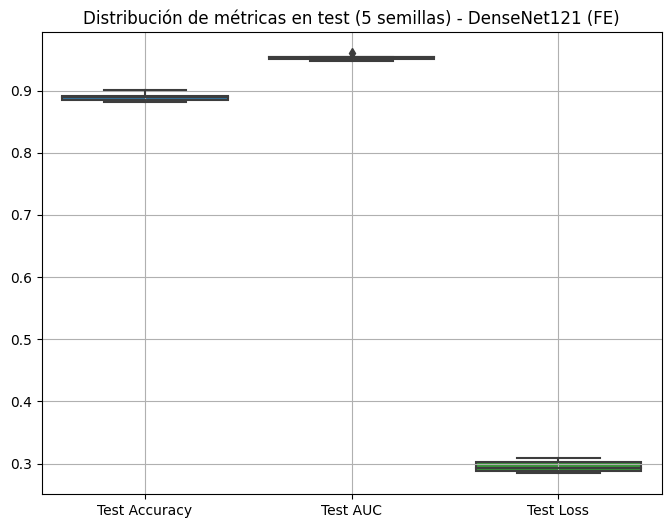

In [19]:
img_size = 150
batch_size = 64
seeds = [0, 1, 2, 3, 4]

results_densenet_list = []
histories_densenet = {}
models_densenet = {}

test_paths, test_labels = get_image_paths_labels(test_dir)
test_df = pd.DataFrame({'filename': test_paths, 'label': test_labels})

for seed in seeds:
    print(f"\n=== SEMILLA {seed} ===")

    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Preparar datos
    train_df, val_df = get_dataframes(train_dir, val_dir, seed)
    train_generator, val_generator, test_generator = get_data_generators(train_df, val_df, test_df, img_size, batch_size, seed)
    
    # Ajuste de pesos
    class_weights = get_class_weights(train_df)
    
    # Crear modelo DenseNet121
    model_densenet = build_densenet_model(img_size)
    
    # Callbacks
    callbacks = get_callbacks()
    
    # Entrenamiento
    history_densenet = model_densenet.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        class_weight=class_weights,
        callbacks=callbacks,
    )

    histories_densenet[seed] = history_densenet
    models_densenet[seed] = model_densenet
    
    # Evaluación en test
    results_densenet = model_densenet.evaluate(test_generator, verbose=0)
    print(f"Test Loss: {results_densenet[0]:.4f}")
    print(f"Test Accuracy: {results_densenet[1]:.4f}")
    print(f"AUC: {results_densenet[2]:.4f}")
    
    # Guardar resultados
    results_densenet_list.append({
        'Seed': seed,
        'Test Loss': results_densenet[0],
        'Test Accuracy': results_densenet[1],
        'Test AUC': results_densenet[2]
    })

# Mostramos resultados
df_results_densenet = pd.DataFrame(results_densenet_list)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_results_densenet[['Test Accuracy', 'Test AUC', 'Test Loss']])
plt.title('Distribución de métricas en test (5 semillas) - DenseNet121 (FE)')
plt.grid(True)
plt.show()

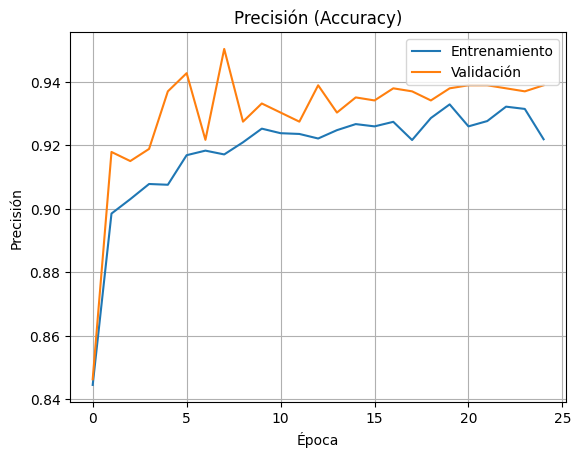

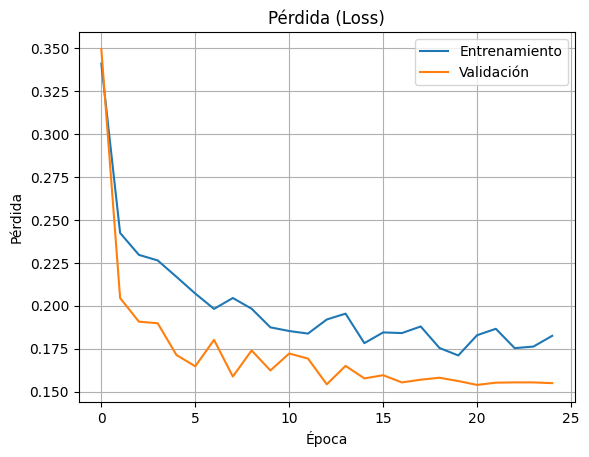

In [24]:
# Elegimos semilla
history_densenet = histories_densenet[4] 

# Accuracy
plt.plot(history_densenet.history['accuracy'], label='Entrenamiento')
plt.plot(history_densenet.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_densenet.history['loss'], label='Entrenamiento')
plt.plot(history_densenet.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()


## **Fine-tuning D**

#### Tras realizar feature extraction, el siguiente paso es el fine-tuning.

#### Descongelamos parte de las capas del modelo preentrenado para permitir que se ajusten mejor a nuestro dataset médico. De esta forma el modelo puede adaptar los patrones aprendidos en ImageNet a los patrones más específicos presentes en las radiografías del dataset.

#### En este caso:
#### - Se descongelan las capas de índice 150 en adelante (últimas 277). El modelo tiene 427 capas en total.
#### - Se recompila el modelo con una **tasa de aprendizaje muy baja (`1e-5`)** para no sobrescribir los pesos preentrenados. Es práctica habitual en fine-tuning o incluso mas bajos. Recordemos el learning rate por defecto en Adam es 0,001.

#### Este ajuste fino permite aprovechar lo mejor del aprendizaje previo.

In [17]:
def build_densenet_model_ft(img_size=224, learning_rate=1e-5):
    # Modelo base
    base_model_densenet_ft = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model_densenet_ft.trainable = True
    for layer in base_model_densenet_ft.layers[:150]:
        layer.trainable = False

    # Top model
    x = base_model_densenet_ft.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model_densenet_ft = Model(inputs=base_model_densenet_ft.input, outputs=output)
    model_densenet_ft.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy', AUC(name='auc')]
    )
    return model_densenet_ft

model_densenet_ft = build_densenet_model_ft()
model_densenet_ft.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,172,929 (27.36 MB)

 Trainable params: 5,586,625 (21.31 MB)

 Non-trainable params: 1,586,304 (6.05 MB)

**Resumen arquitectura:**

Total params: 7,172,929 (27.36 MB)

Trainable params: 5,586,625 (21.31 MB)

Non-trainable params: 1,586,304 (6.05 MB)





=== SEMILLA 0 ===
Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1754841447.273860     110 service.cc:148] XLA service 0x7d8444101c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754841447.275509     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754841447.275543     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754841454.163097     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754841504.502467     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.4494 - auc: 0.6280 - loss: 0.9095 - val_accuracy: 0.4002 - val_auc: 0.9292 - val_loss: 0.8326 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 980ms/step - accuracy: 0.6273 - auc: 0.8680 - loss: 0.6855 - val_accuracy: 0.5377 - val_auc: 0.9691 - val_loss: 0.7614 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 946ms/step - accuracy: 0.7424 - auc: 0.9193 - loss: 0.5406 - val_accuracy: 0.6810 - val_auc: 0.9796 - val_loss: 0.6603 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 963ms/step - accuracy: 0.8148 - auc: 0.9486 - loss: 0.4351 - val_accuracy: 0.7994 - val_auc: 0.9837 - val_loss: 0.5368 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 961ms/step - accuracy: 0.8800 - auc: 0.9678 - loss: 0.3510 - val_accuracy: 0.8615 - val_auc: 0.9860 - val_loss: 0.4343 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 960ms/step - accuracy: 0.9

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.6971 - auc: 0.5388 - loss: 0.6421 - val_accuracy: 0.7880 - val_auc: 0.8971 - val_loss: 0.5344 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 946ms/step - accuracy: 0.7980 - auc: 0.7950 - loss: 0.4494 - val_accuracy: 0.7851 - val_auc: 0.9534 - val_loss: 0.4862 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 956ms/step - accuracy: 0.8541 - auc: 0.9010 - loss: 0.3615 - val_accuracy: 0.8300 - val_auc: 0.9679 - val_loss: 0.4178 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 952ms/step - accuracy: 0.8923 - auc: 0.9477 - loss: 0.2894 - val_accuracy: 0.8539 - val_auc: 0.9747 - val_loss: 0.3643 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 951ms/step - accuracy: 0.8985 - auc: 0.9550 - loss: 0.2656 - val_accuracy: 0.8682 - val_auc: 0.9785 - val_loss: 0.3178 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 953ms/step - ac

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.2746 - auc: 0.6373 - loss: 1.4909 - val_accuracy: 0.2579 - val_auc: 0.9407 - val_loss: 2.0049 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 943ms/step - accuracy: 0.3273 - auc: 0.8291 - loss: 1.2320 - val_accuracy: 0.2646 - val_auc: 0.9576 - val_loss: 1.7886 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 953ms/step - accuracy: 0.4210 - auc: 0.9159 - loss: 0.9748 - val_accuracy: 0.3620 - val_auc: 0.9486 - val_loss: 1.5511 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 954ms/step - accuracy: 0.5629 - auc: 0.9487 - loss: 0.8021 - val_accuracy: 0.5721 - val_auc: 0.9594 - val_loss: 1.1979 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 952ms/step - accuracy: 0.7320 - auc: 0.9544 - loss: 0.6224 - val_accuracy: 0.7564 - val_auc: 0.9711 - val_loss: 0.8227 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 986ms/step - ac

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.5374 - auc: 0.5347 - loss: 0.7848 - val_accuracy: 0.5358 - val_auc: 0.8107 - val_loss: 0.6997 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 937ms/step - accuracy: 0.6863 - auc: 0.7711 - loss: 0.5957 - val_accuracy: 0.6237 - val_auc: 0.9678 - val_loss: 0.6245 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 937ms/step - accuracy: 0.7711 - auc: 0.8973 - loss: 0.4732 - val_accuracy: 0.7182 - val_auc: 0.9821 - val_loss: 0.5623 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 941ms/step - accuracy: 0.8271 - auc: 0.9317 - loss: 0.4117 - val_accuracy: 0.8204 - val_auc: 0.9861 - val_loss: 0.4573 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 939ms/step - accuracy: 0.8756 - auc: 0.9585 - loss: 0.3400 - val_accuracy: 0.8443 - val_auc: 0.9881 - val_loss: 0.4099 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 939ms/step - ac

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.4722 - auc: 0.5497 - loss: 0.8744 - val_accuracy: 0.6246 - val_auc: 0.7000 - val_loss: 0.6408 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 943ms/step - accuracy: 0.6175 - auc: 0.7631 - loss: 0.6850 - val_accuracy: 0.5941 - val_auc: 0.9350 - val_loss: 0.6457 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 947ms/step - accuracy: 0.7266 - auc: 0.8943 - loss: 0.5470 - val_accuracy: 0.6772 - val_auc: 0.9710 - val_loss: 0.5960 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 951ms/step - accuracy: 0.7764 - auc: 0.9261 - loss: 0.4739 - val_accuracy: 0.7679 - val_auc: 0.9797 - val_loss: 0.5188 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 958ms/step - accuracy: 0.8441 - auc: 0.9497 - loss: 0.3897 - val_accuracy: 0.8080 - val_auc: 0.9833 - val_loss: 0.4515 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 951ms/step - ac

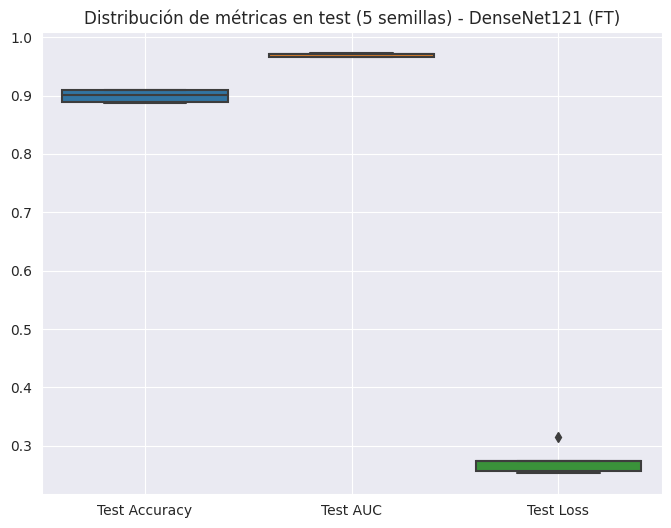

In [18]:
img_size = 150
batch_size = 64
learning_rate=1e-5
seeds = [0, 1, 2, 3, 4]

results_densenet_ft_list = []
histories_densenet_ft = {}
models_densenet_ft = {}

test_paths, test_labels = get_image_paths_labels(test_dir)
test_df = pd.DataFrame({'filename': test_paths, 'label': test_labels})

for seed in seeds:
    print(f"\n=== SEMILLA {seed} ===")

    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Preparar datos
    train_df, val_df = get_dataframes(train_dir, val_dir, seed)
    train_generator, val_generator, test_generator = get_data_generators(train_df, val_df, test_df, img_size, batch_size, seed)
    
    # Ajuste de pesos
    class_weights = get_class_weights(train_df)
    
    # Crear modelo Custom CNN
    model_densenet_ft = build_densenet_model_ft(img_size, learning_rate)
    
    # Callbacks
    callbacks = get_callbacks()
    
    # Entrenamiento
    history_densenet_ft = model_densenet_ft.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        class_weight=class_weights,
        callbacks=callbacks,
    )

    histories_densenet_ft[seed] = history_densenet_ft
    models_densenet_ft[seed] = model_densenet_ft
    
    # Evaluación en test
    results_densenet_ft = model_densenet_ft.evaluate(test_generator, verbose=0)
    print(f"Test Loss: {results_densenet_ft[0]:.4f}")
    print(f"Test Accuracy: {results_densenet_ft[1]:.4f}")
    print(f"AUC: {results_densenet_ft[2]:.4f}")
    
    # Guardar resultados
    results_densenet_ft_list.append({
        'Seed': seed,
        'Test Loss': results_densenet_ft[0],
        'Test Accuracy': results_densenet_ft[1],
        'Test AUC': results_densenet_ft[2]
    })

# Mostramos resultados
df_results_densenet_ft = pd.DataFrame(results_densenet_ft_list)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_results_densenet_ft[['Test Accuracy', 'Test AUC', 'Test Loss']])
plt.title('Distribución de métricas en test (5 semillas) - DenseNet121 (FT)')
plt.grid(True)
plt.show()

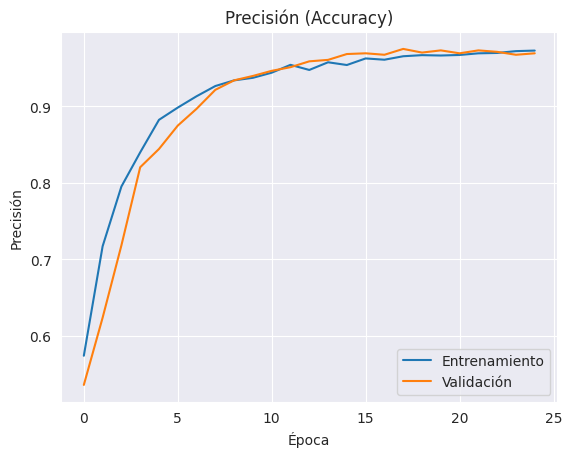

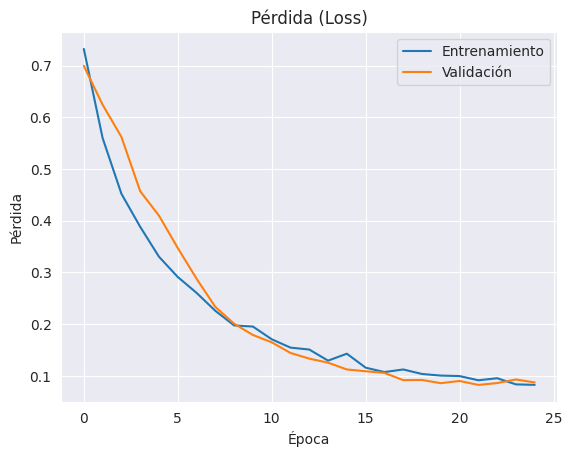

In [19]:
# Elegimos semilla
history_densenet_ft = histories_densenet_ft[3] 

# Accuracy
plt.plot(history_densenet_ft.history['accuracy'], label='Entrenamiento')
plt.plot(history_densenet_ft.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_densenet_ft.history['loss'], label='Entrenamiento')
plt.plot(history_densenet_ft.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

## **Evaluación del Rendimiento DenseNet**

### **DenseNet121 con Feature Extraction**

10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step 


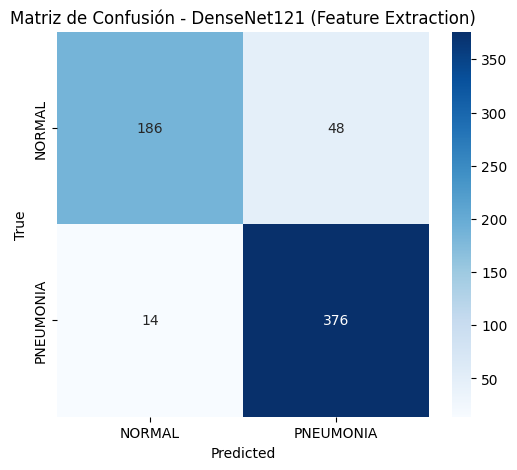


Métricas de Clasificación - DenseNet121 (Feature Extraction)
              precision    recall  f1-score   support

      NORMAL       0.93      0.79      0.86       234
   PNEUMONIA       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624

AUC-ROC: 0.9540
Especificidad: 0.7949


In [25]:
# Elegimos la semilla para ver las métricas de esa ejecución
y_true, y_pred, y_pred_probs = evaluar_modelo(models_densenet[4], test_generator, nombre_modelo="DenseNet121 (Feature Extraction)")

#### **Matriz de Confusión:**
* #### Clasifica correctamente la mayoría de los casos de **PNEUMONIA**: 376 sobre 390.
* #### También se clasifican adecuadamente la mayoría de las imágenes **NORMALES**: 186 aciertos sobre 234.

#### **Métricas de Clasificación:**

#### **1. Precisión**

* #### NORMAL → 0.93. El 93% de las veces que el modelo predice que es normal, acierta.
* #### PNEUMONIA → 0.89. El 89% de las veces que predice neumonía, acierta.

#### **2. Recall (Sensibilidad)**

* #### NORMAL → 0.79. El modelo detecta correctamente el 79% de las imágenes normales.
* #### PNEUMONIA → 0.96. El modelo identifica correctamente el 96% de los casos con neumonía, lo cual es muy relevante en diagnóstico médico.

#### **3. F1-Score**
 * #### Buen equilibrio entre precisión y sensibilidad, especialmente alto en la clase neumonía (0.92), lo que refuerza su utilidad diagnóstica.

#### **4. Accuracy**
* #### Precisión global del modelo: 0.90. Es un valor alto y consistente. Dado que el dataset está balanceado, esta métrica es representativa.

#### **AUC-ROC (0.9540):** Indica excelente capacidad del modelo para distinguir entre ambas clases. Cuanto más cerca de 1, mejor.

#### **Especificidad (0.7949):** Mide la capacidad del modelo para identificar correctamente los casos normales. Este valor, aunque más bajo que el recall de la clase neumonía, es esperable en entornos médicos donde se prioriza reducir falsos negativos sobre falsos positivos.

### **DenseNet121 con Fine-Tuning**

#### Fine-tuning ha mejorado algo la media de los valores. Siendo la mayoria en Feature Extraction un porcentaje de accuracy algo superior de 88, y en Fine-tuning superior a 90

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 420ms/step


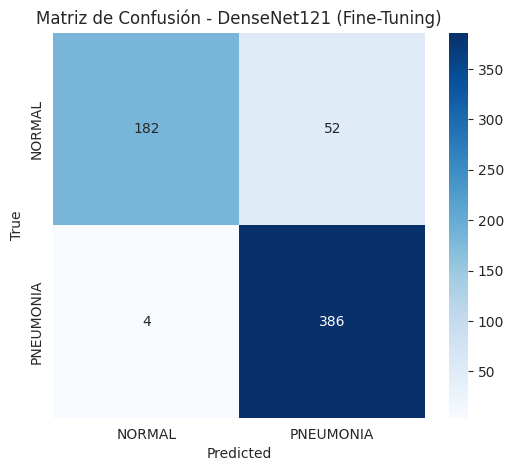


Métricas de Clasificación - DenseNet121 (Fine-Tuning)
              precision    recall  f1-score   support

      NORMAL       0.98      0.78      0.87       234
   PNEUMONIA       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624

AUC-ROC: 0.9722
Especificidad: 0.7778


In [25]:
# Elegimos la semilla para ver las métricas de esa ejecución
y_true, y_pred, y_pred_probs = evaluar_modelo(models_densenet_ft[3], test_generator, nombre_modelo="DenseNet121 (Fine-Tuning)")

#### **Matriz de Confusión:**
* #### Clasifica correctamente la mayoría de los casos de PNEUMONIA: 386 sobre 390.
* #### También se clasifican adecuadamente la mayoría de las imágenes NORMALES: 182 aciertos sobre 234.

#### **Métricas de Clasificación:**

#### **1. Precisión**

* #### NORMAL →  0.98. El 98% de las veces que el modelo predice que es normal, acierta.
* #### PNEUMONIA → 0.88. El 88% de las veces que predice neumonía, acierta.

#### **2. Recall (Sensibilidad)**

* #### NORMAL → 0.78. El modelo detecta correctamente el 78% de las imágenes normales.
* #### PNEUMONIA →  0.99. El modelo identifica correctamente el 99% de los casos con neumonía, lo cual es extremadamente relevante en diagnóstico médico.

#### **3. F1-Score**
 * #### Buen equilibrio entre precisión y sensibilidad, especialmente alto en la clase neumonía (0.93), lo que refuerza su utilidad diagnóstica.

#### **4. Accuracy**
* #### Precisión global del modelo: 0.91. Es un valor alto y consistente. Dado que el dataset está balanceado, esta métrica es representativa.

#### **AUC-ROC (0.9722):** Indica excelente capacidad del modelo para distinguir entre ambas clases. Cuanto más cerca de 1, mejor.

#### **Especificidad (0.7778):** Mide la capacidad del modelo para identificar correctamente los casos normales. Este valor, aunque más bajo que el recall de la clase neumonía, es esperable en entornos médicos donde se prioriza reducir falsos negativos sobre falsos positivos.

## **Entrenamiento del Modelo 3: ResNet101**

#### Para este modelo se han realizado múltiples pruebas y ajustes, como se detallará más adelante. Dado que los resultados no han sido tan satisfactorios como con otros enfoques, se podría contemplar el uso de alternativas distintas a las arquitecturas CNN puras. Existe la posibilidad de utilizar **ResNet101 únicamente como extractor de características** (feature extractor), y conectar su salida a un **clasificador tradicional** de machine learning, como **SVM, Random Forest o XGBoost**.

#### En este caso sería un modelo hídrido, pues mezcla un modelo clásico de ML con redes neuronales. Esta estrategia hídrida puede funcionar mejor cuando se trabaja con datasets pequeños y puede aportar una menor complejidad del modelo y menor riesgo de sobreajuste.

## **Feature Extraction R**

### **Modelo base**
#### Mismo procedimiento que para DenseNet121. ResNet101 tiene 101 capas efectivas, es decir, con pesos ajustables que contribuyen al aprendizaje. A pesar de tener menos capas efectivas que DenseNet121, estás tiene mas parámetros, por lo que existe mayor riesgo de overfitting en este modelo.

#### Como particularidad, este modelo utiliza **residual connections** que es lo que le da su propio nombre: ResNet (Residual Network). Para ello utiliza unas capas **Add()** que se usan dentro del extractor convolucional para facilitar el entrenamiento (evitan el *vanishing gradient*).

### **Top model**
#### Inicialmente, para hacer una comparación "justa" con DenseNet121, se utilizó la misma arquitectura de capa de clasificación ("top model") sobre ResNet101. Mismo ajuste de capas densas, dropout y normalización.

#### Sin embargo, los resultados obtenidos con esta configuración fueron inferiores en ResNet101, lo que indicaba que esta arquitectura no se ajusta de manera óptima a las características internas de este modelo.

#### Se probaron múltiples arquitecturas de top model para ResNet101, fue finalmente una arquitectura más profunda y compleja la que mejor resultado ofreció. En principio, una arquitectura mas simple es lo recomendable pues: 
* #### Al ser un dataset pequeño, un top model demasiado profundo con mas neuronas, equivale a mas parámetros adicionales, lo que facilita que el modelo memorize en vez de aprender patrones generales.
#### El motivo por el que una arquitectura mas profunda ha podido dar mejores resultados son los siguientes:
* #### **Regularización efectiva:** la arquitectura incluye varias capas de Dropout y BatchNormalization, que ayuda a controlar el sobreajuste incluso con un número mayor de parámetros.
* #### **Mejoras del dataset:** tanto el ajuste del balanceo como el data augmentation aplicado, ofrece mas variabilidad de los datos, lo que permite aprovechar los features del modelo sin caer en sobreajuste.

#### **Funciones de activación ¿ReLU o Swish?**
#### Tambien se probó con estas diferentes funciones matemáticas (aplicadas a salida de las neuronas). En principio Swish es una activación que ha demostrado superar a ReLU en tareas de visión. 
#### La diferencia es que en **ReLU**, si el valor es positivo lo deja pasar, si en negativo lo convierte a 0. Rápido de calcular y funciona muy bien en la mayoría de problemas, sin embargo, en regiones negativas los flujos de gradiente pueden no ser suaves, y algunas neuronas pueden morir (quedarse siempre en 0).

#### **Swish** en cambio, deja pasar suavemente valores negativos en lugar de dejarlos a 0. No mata neuronas (mejor flujo de gradiente). No siempre mejora respecto a ReLU, aunque se supone que en redes grandes o profundas si se nota mejoría. 
#### En DenseNet no se valoró porque la red fue originalmente diseñada con ReLU, tiene conexiones densas y el flujo de gradiente ya es de por sí muy bueno (junto con otras características). 

#### A pesar de sus beneficios, en la práctica no ha dado una mejora del rendimiento, al menos para este dataset, modelo (ResNet101), y arquitectura de la capa de clasificación empleada. Posibles motivos:
* #### Uso de BatchNormalization: estabiliza los gradientes.
* #### ResNet ya tiene buenas propiedades de flujo de información (residual connections).
* #### Swish puede requerir más datos y mayor diversidad para mostrar su superioridad. En datasets no masivos o con cierto desbalance, la menor complejidad de ReLU puede ayudar.
* #### Aunque ciertos estudios han demostrado que Swish tiende a superar a ReLU en redes profundas y tareas complejas, también se ha observado que la diferencia suele ser pequeña y depende del ajuste de hiperparámetros, la regularización y la calidad del preprocesamiento.

In [17]:
def build_resnet_model(img_size=150):
    # Modelo base
    base_model_resnet = ResNet101(weights='imagenet',include_top=False,input_shape=(img_size, img_size, 3))
    base_model_resnet.trainable = False

    # Top model
    x = base_model_resnet.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)  
    
    model_resnet = Model(inputs=base_model_resnet.input, outputs=output)
    
    model_resnet.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model_resnet

model_resnet = build_resnet_model()
model_resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 43,233,153 (164.92 MB)

 Trainable params: 570,369 (2.18 MB)

 Non-trainable params: 42,662,784 (162.75 MB)

**Resumen arquitectura:**

Total params: 43,233,153 (164.92 MB)

Trainable params: 570,369 (2.18 MB)

Non-trainable params: 42,662,784 (162.75 MB)


=== SEMILLA 0 ===
Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1754911837.354292     104 service.cc:148] XLA service 0x7cd770003550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754911837.355071     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754911837.355093     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754911840.591663     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1754911848.913090     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7905 - auc: 0.8098 - loss: 0.4444 - val_accuracy: 0.7822 - val_auc: 0.8931 - val_loss: 0.5676 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8720 - auc: 0.9320 - loss: 0.2893 - val_accuracy: 0.7536 - val_auc: 0.9396 - val_loss: 0.4929 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8954 - auc: 0.9473 - loss: 0.2565 - val_accuracy: 0.8625 - val_auc: 0.9505 - val_loss: 0.4146 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 993ms/step - accuracy: 0.8944 - auc: 0.9443 - loss: 0.2564 - val_accuracy: 0.8577 - val_auc: 0.9373 - val_loss: 0.3653 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 992ms/step - accuracy: 0.9027 - auc: 0.9532 - loss: 0.2420 - val_accuracy: 0.8548 - val_auc: 0.9512 - val_loss: 0.3219 - learning_rate: 0.0010
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9148 - auc: 0.9602 - loss: 0.2

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7686 - auc: 0.8140 - loss: 0.4750 - val_accuracy: 0.7421 - val_auc: 0.9341 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 996ms/step - accuracy: 0.8732 - auc: 0.9289 - loss: 0.2992 - val_accuracy: 0.8739 - val_auc: 0.9532 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8983 - auc: 0.9510 - loss: 0.2459 - val_accuracy: 0.8672 - val_auc: 0.9411 - val_loss: 0.4366 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.8963 - auc: 0.9504 - loss: 0.2478
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8964 - auc: 0.9504 - loss: 0.2478 - val_accuracy: 0.8902 - val_auc: 0.9462 - val_loss: 0.3978 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9070 - auc: 0.9588 - loss: 0.2280 - val

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7454 - auc: 0.7810 - loss: 0.4922 - val_accuracy: 0.2875 - val_auc: 0.9159 - val_loss: 0.7067 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8668 - auc: 0.9316 - loss: 0.2950 - val_accuracy: 0.7268 - val_auc: 0.9543 - val_loss: 0.6375 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8861 - auc: 0.9396 - loss: 0.2713 - val_accuracy: 0.8873 - val_auc: 0.9461 - val_loss: 0.4445 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.9046 - auc: 0.9510 - loss: 0.2390
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9045 - auc: 0.9511 - loss: 0.2389 - val_accuracy: 0.8825 - val_auc: 0.9365 - val_loss: 0.3526 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9008 - auc: 0.9506 - loss: 0.2425 - val_ac

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7836 - auc: 0.8078 - loss: 0.4450 - val_accuracy: 0.2579 - val_auc: 0.9235 - val_loss: 0.7505 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8549 - auc: 0.9174 - loss: 0.3145 - val_accuracy: 0.8185 - val_auc: 0.9530 - val_loss: 0.5822 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8807 - auc: 0.9390 - loss: 0.2759 - val_accuracy: 0.9236 - val_auc: 0.9700 - val_loss: 0.4660 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8823 - auc: 0.9434 - loss: 0.2632 - val_accuracy: 0.8252 - val_auc: 0.9652 - val_loss: 0.3550 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - accuracy: 0.9006 - auc: 0.9523 - loss: 0.2390
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.9005 - auc: 0.9523 - loss: 0.2390 - val_ac

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.7691 - auc: 0.8068 - loss: 0.4579 - val_accuracy: 0.8233 - val_auc: 0.8946 - val_loss: 0.6297 - learning_rate: 0.0010
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8771 - auc: 0.9335 - loss: 0.2868 - val_accuracy: 0.8863 - val_auc: 0.9392 - val_loss: 0.5380 - learning_rate: 0.0010
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8848 - auc: 0.9379 - loss: 0.2737 - val_accuracy: 0.8281 - val_auc: 0.9207 - val_loss: 0.4510 - learning_rate: 0.0010
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8925 - auc: 0.9466 - loss: 0.2592 - val_accuracy: 0.8376 - val_auc: 0.9582 - val_loss: 0.3296 - learning_rate: 0.0010
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9062 - auc: 0.9558 - loss: 0.2364 - val_accuracy: 0.8539 - val_auc: 0.9448 - val_loss: 0.3210 - learning_rate: 0.0010
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8964 - auc: 0.9517 - loss

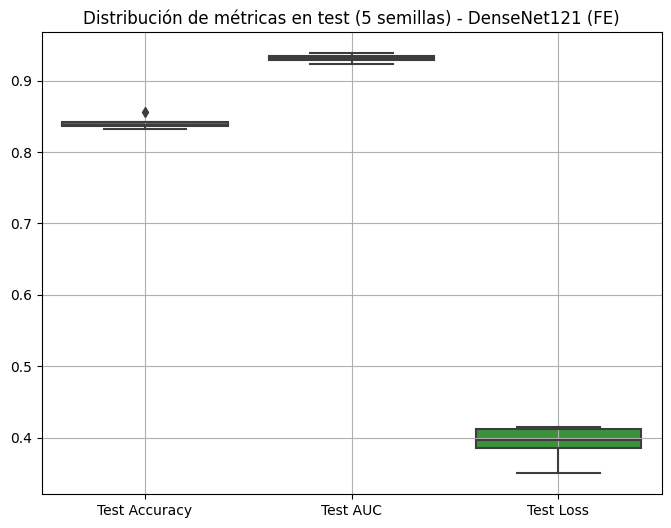

In [18]:
img_size = 150
batch_size = 64
seeds = [0, 1, 2, 3, 4]

results_resnet_list = []
histories_resnet = {}
models_resnet = {}

test_paths, test_labels = get_image_paths_labels(test_dir)
test_df = pd.DataFrame({'filename': test_paths, 'label': test_labels})

for seed in seeds:
    print(f"\n=== SEMILLA {seed} ===")

    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Preparar datos
    train_df, val_df = get_dataframes(train_dir, val_dir, seed)
    train_generator, val_generator, test_generator = get_data_generators(train_df, val_df, test_df, img_size, batch_size, seed)
    
    # Ajuste de pesos
    class_weights = get_class_weights(train_df)
    
    # Crear modelo Custom CNN
    model_resnet = build_resnet_model(img_size)
    
    # Callbacks
    callbacks = get_callbacks()
    
    # Entrenamiento
    history_resnet = model_resnet.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        class_weight=class_weights,
        callbacks=callbacks,
    )

    histories_resnet[seed] = history_resnet
    models_resnet[seed] = model_resnet
    
    # Evaluación en test
    results_resnet = model_resnet.evaluate(test_generator, verbose=0)
    print(f"Test Loss: {results_resnet[0]:.4f}")
    print(f"Test Accuracy: {results_resnet[1]:.4f}")
    print(f"AUC: {results_resnet[2]:.4f}")
    
    # Guardar resultados
    results_resnet_list.append({
        'Seed': seed,
        'Test Loss': results_resnet[0],
        'Test Accuracy': results_resnet[1],
        'Test AUC': results_resnet[2]
    })

# Mostramos resultados
df_results_resnet = pd.DataFrame(results_resnet_list)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_results_resnet[['Test Accuracy', 'Test AUC', 'Test Loss']])
plt.title('Distribución de métricas en test (5 semillas) - DenseNet121 (FE)')
plt.grid(True)
plt.show()

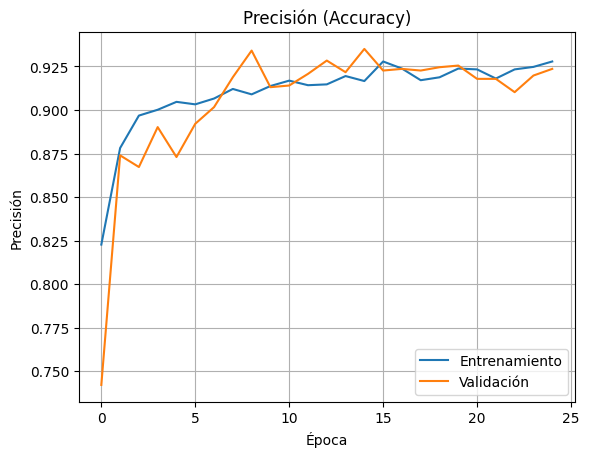

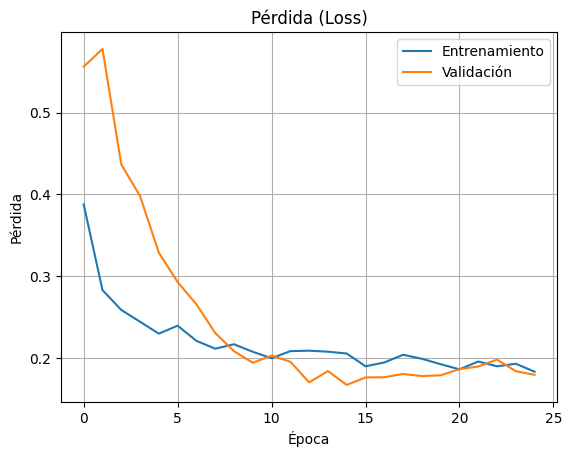

In [19]:
# Elegimos semilla
history_resnet = histories_resnet[1] 

# Accuracy
plt.plot(history_resnet.history['accuracy'], label='Entrenamiento')
plt.plot(history_resnet.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_resnet.history['loss'], label='Entrenamiento')
plt.plot(history_resnet.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()


## **Fine-tuning R**

#### Siguiendo la estrategia aplicada en modelos anteriores, procedemos a realizar fine-tuning sobre la red ResNet101, desbloqueando una parte de sus capas para permitir que se ajusten al dominio específico de nuestro conjunto de datos.

#### En este caso concreto:

* #### Se descongelan las capas desde la número 300 en adelante, es decir, las últimas 45 capas.

#### Se han hecho muchas pruebas sobre este modelo, pues para mi sorprensa, funcionaba en la mayoria de los casos mejor con todas las capas congeladas que descongelando y permitiendo que aprendiese sobre el dataset específico. Por este motivo, se han descogelado finalmente un número creo que reducido de capas. Aún asi la mejora respecto a feature extraction ha sido ligera. Además el aprendizaje ha mostrado inestabilidad, lo que se puede ver en las gráficas siguientes.

#### Las curvas de validación indican inestabilidad en el rendimiento sobre datos nuevos. El modelo no esta generalizando de forma estable.
* #### Dataset pequeño
* #### Learning rate alto

#### Además, las variaciones en el loss de validación sugieren que la confianza del modelo en sus predicciones es inconsistente. Posibles solucione serían:
* #### Reducir ligeramente el learning rate (probar con 5e-6 o incluso 1e-6).
* #### Aumentar el dropout ligeramente

In [21]:
def build_resnet_model_ft(img_size=224, learning_rate=1e-5):
    # Modelo base
    base_model_resnet_ft = ResNet101(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
    base_model_resnet_ft.trainable = True
    for layer in base_model_resnet_ft.layers[:300]:
        layer.trainable = False

    # Top model
    x = base_model_resnet_ft.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)  
    
    model_resnet_ft = Model(inputs=base_model_resnet_ft.input, outputs=output)
    
    model_resnet_ft.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-5),
        metrics=['accuracy', AUC(name='auc')]
    )
    return model_resnet_ft

model_resnet_ft = build_resnet_model_ft()
model_resnet_ft.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 43,233,153 (164.92 MB)

 Trainable params: 16,667,137 (63.58 MB)

 Non-trainable params: 26,566,016 (101.34 MB)

**Resumen arquitectura:**

Total params: 43,233,153 (164.92 MB)

Trainable params: 16,667,137 (63.58 MB)

Non-trainable params: 26,566,016 (101.34 MB)


=== SEMILLA 0 ===
Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.7496 - auc: 0.6648 - loss: 0.5623 - val_accuracy: 0.7421 - val_auc: 0.3550 - val_loss: 0.5849 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8393 - auc: 0.8900 - loss: 0.3582 - val_accuracy: 0.7421 - val_auc: 0.7449 - val_loss: 0.5565 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8620 - auc: 0.9077 - loss: 0.3323 - val_accuracy: 0.7421 - val_auc: 0.7442 - val_loss: 0.5537 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8695 - auc: 0.9247 - loss: 0.3003 - val_accuracy: 0.7421 - val_auc: 0.8467 - val_loss: 0.5402 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8951 - auc: 0.9451 - loss: 0.2620 - val_accuracy: 0.8367 - val_auc: 0.9581 - val_loss: 0.3797 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9051 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5673 - auc: 0.7017 - loss: 0.7729 - val_accuracy: 0.2579 - val_auc: 0.5440 - val_loss: 0.7716 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7552 - auc: 0.8454 - loss: 0.5199 - val_accuracy: 0.2818 - val_auc: 0.4767 - val_loss: 0.7314 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8415 - auc: 0.9146 - loss: 0.3797 - val_accuracy: 0.6294 - val_auc: 0.5998 - val_loss: 0.6864 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8556 - auc: 0.9151 - loss: 0.3484 - val_accuracy: 0.7813 - val_auc: 0.8910 - val_loss: 0.5351 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8830 - auc: 0.9388 - loss: 0.3066 - val_accuracy: 0.8395 - val_auc: 0.9154 - val_loss: 0.4211 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8773 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.5378 - auc: 0.6714 - loss: 0.8136 - val_accuracy: 0.5377 - val_auc: 0.5158 - val_loss: 0.6910 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 986ms/step - accuracy: 0.7796 - auc: 0.8801 - loss: 0.4819 - val_accuracy: 0.4518 - val_auc: 0.5825 - val_loss: 0.7052 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8350 - auc: 0.9006 - loss: 0.3965 - val_accuracy: 0.6275 - val_auc: 0.7260 - val_loss: 0.6574 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 990ms/step - accuracy: 0.8778 - auc: 0.9341 - loss: 0.3163 - val_accuracy: 0.8539 - val_auc: 0.8404 - val_loss: 0.5464 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 996ms/step - accuracy: 0.8859 - auc: 0.9376 - loss: 0.3023 - val_accuracy: 0.8854 - val_auc: 0.9167 - val_loss: 0.3724 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6743 - auc: 0.7133 - loss: 0.6041 - val_accuracy: 0.6791 - val_auc: 0.6204 - val_loss: 0.6882 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7990 - auc: 0.8536 - loss: 0.4452 - val_accuracy: 0.7421 - val_auc: 0.3574 - val_loss: 0.6280 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8427 - auc: 0.9039 - loss: 0.3641 - val_accuracy: 0.7421 - val_auc: 0.6606 - val_loss: 0.5830 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8660 - auc: 0.9229 - loss: 0.3275 - val_accuracy: 0.7421 - val_auc: 0.8997 - val_loss: 0.4953 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8933 - auc: 0.9428 - loss: 0.2769 - val_accuracy: 0.8357 - val_auc: 0.9645 - val_loss: 0.3597 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8929 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.6634 - auc: 0.7110 - loss: 0.6166 - val_accuracy: 0.4021 - val_auc: 0.3716 - val_loss: 0.6924 - learning_rate: 1.0000e-05
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8233 - auc: 0.8768 - loss: 0.4144 - val_accuracy: 0.4594 - val_auc: 0.5410 - val_loss: 0.6942 - learning_rate: 1.0000e-05
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 999ms/step - accuracy: 0.8567 - auc: 0.9098 - loss: 0.3469 - val_accuracy: 0.7517 - val_auc: 0.8326 - val_loss: 0.6019 - learning_rate: 1.0000e-05
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8819 - auc: 0.9322 - loss: 0.2966 - val_accuracy: 0.7431 - val_auc: 0.9286 - val_loss: 0.5912 - learning_rate: 1.0000e-05
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8828 - auc: 0.9308 - loss: 0.2954 - val_accuracy: 0.9035 - val_auc: 0.9558 - val_loss: 0.4128 - learning_rate: 1.0000e-05
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.89

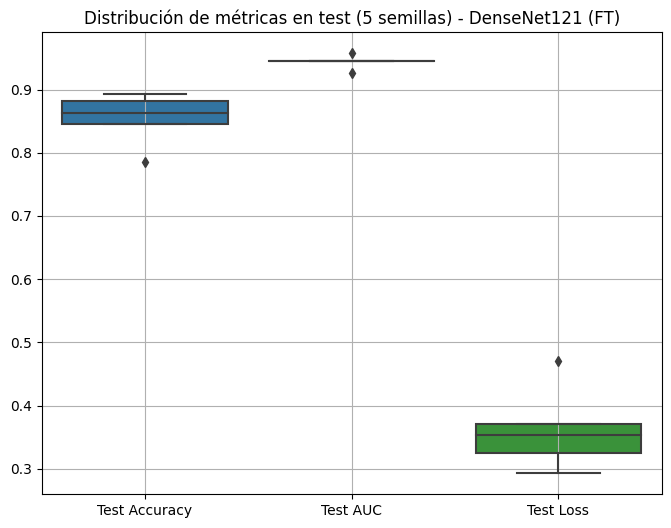

In [22]:
img_size = 150
batch_size = 64
learning_rate=1e-5
seeds = [0, 1, 2, 3, 4]

results_resnet_ft_list = []
histories_resnet_ft = {}
models_resnet_ft = {}

test_paths, test_labels = get_image_paths_labels(test_dir)
test_df = pd.DataFrame({'filename': test_paths, 'label': test_labels})

for seed in seeds:
    print(f"\n=== SEMILLA {seed} ===")

    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Preparar datos
    train_df, val_df = get_dataframes(train_dir, val_dir, seed)
    train_generator, val_generator, test_generator = get_data_generators(train_df, val_df, test_df, img_size, batch_size, seed)
    
    # Ajuste de pesos
    class_weights = get_class_weights(train_df)
    
    # Crear modelo Custom CNN
    model_resnet_ft = build_resnet_model_ft(img_size, learning_rate)
    
    # Callbacks
    callbacks = get_callbacks()
    
    # Entrenamiento
    history_resnet_ft = model_resnet_ft.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        class_weight=class_weights,
        callbacks=callbacks,
    )

    histories_resnet_ft[seed] = history_resnet_ft
    models_resnet_ft[seed] = model_resnet_ft
    
    # Evaluación en test
    results_resnet_ft = model_resnet_ft.evaluate(test_generator, verbose=0)
    print(f"Test Loss: {results_resnet_ft[0]:.4f}")
    print(f"Test Accuracy: {results_resnet_ft[1]:.4f}")
    print(f"AUC: {results_resnet_ft[2]:.4f}")
    
    # Guardar resultados
    results_resnet_ft_list.append({
        'Seed': seed,
        'Test Loss': results_resnet_ft[0],
        'Test Accuracy': results_resnet_ft[1],
        'Test AUC': results_resnet_ft[2]
    })

# Mostramos resultados
df_results_resnet_ft = pd.DataFrame(results_resnet_ft_list)

plt.figure(figsize=(8, 6))
sns.boxplot(data=df_results_resnet_ft[['Test Accuracy', 'Test AUC', 'Test Loss']])
plt.title('Distribución de métricas en test (5 semillas) - DenseNet121 (FT)')
plt.grid(True)
plt.show()

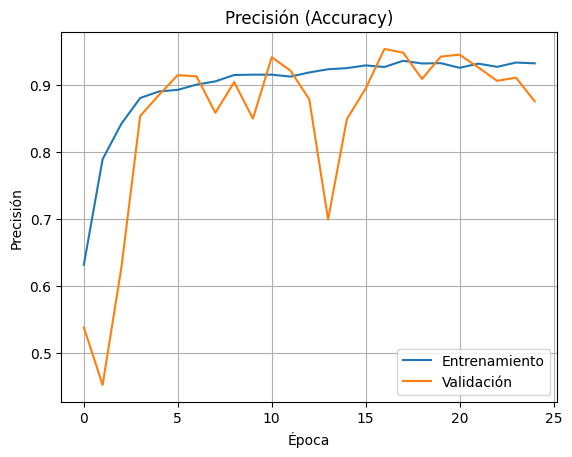

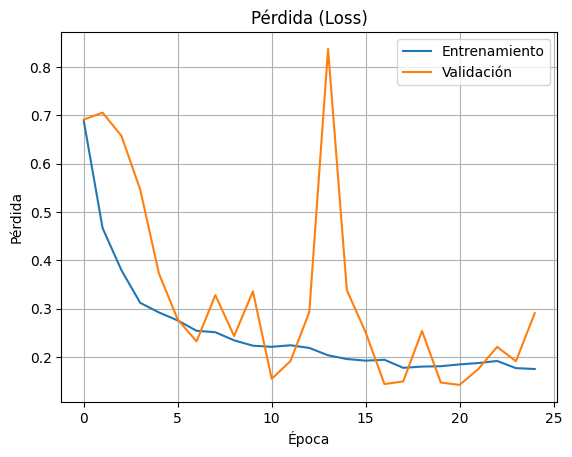

In [25]:
# Elegimos semilla
history_resnet_ft = histories_resnet_ft[2] 

# Accuracy
plt.plot(history_resnet_ft.history['accuracy'], label='Entrenamiento')
plt.plot(history_resnet_ft.history['val_accuracy'], label='Validación')
plt.title('Precisión (Accuracy)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_resnet_ft.history['loss'], label='Entrenamiento')
plt.plot(history_resnet_ft.history['val_loss'], label='Validación')
plt.title('Pérdida (Loss)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

## **Evaluación del Rendimiento ResNet**

### **ResNet101 con Feature Extraction**

10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 


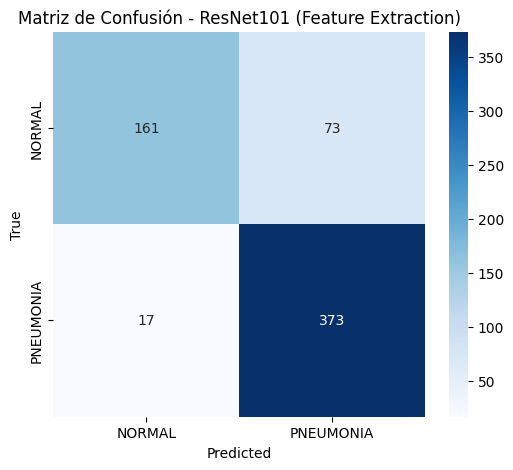


Métricas de Clasificación - ResNet101 (Feature Extraction)
              precision    recall  f1-score   support

      NORMAL       0.90      0.69      0.78       234
   PNEUMONIA       0.84      0.96      0.89       390

    accuracy                           0.86       624
   macro avg       0.87      0.82      0.84       624
weighted avg       0.86      0.86      0.85       624

AUC-ROC: 0.9399
Especificidad: 0.6880


In [20]:
# Elegimos la semilla para ver las métricas de esa ejecución
y_true, y_pred, y_pred_probs = evaluar_modelo(models_resnet[1], test_generator, nombre_modelo="ResNet101 (Feature Extraction)")

#### **Matriz de Confusión:**
* #### Clasifica correctamente la mayoría de los casos de PNEUMONIA: 373 sobre 390.
* #### También se clasifican adecuadamente una buena parte de las imágenes NORMALES: 161 aciertos sobre 234.

#### **Métricas de Clasificación:**

#### **1. Precisión**

* #### NORMAL → 0.90. El 90% de las veces que el modelo predice que es normal, acierta.
* #### PNEUMONIA → 0.84. El 84% de las veces que predice neumonía, acierta.

#### **2. Recall (Sensibilidad)**

* #### NORMAL → 0.69. El modelo detecta correctamente el 69% de las imágenes normales.
* #### PNEUMONIA →  0.96. El modelo identifica correctamente el 96% de los casos con neumonía, lo cual es muy relevante en diagnóstico médico.

#### **3. F1-Score**
 * #### Buen equilibrio entre precisión y sensibilidad, especialmente alto en la clase neumonía (0.89), lo que refuerza su utilidad diagnóstica.

#### **4. Accuracy**
* #### Precisión global del modelo: 0.86. Aunque es un valor razonable, es algo inferior al de otros modelos probados, lo que indica margen de mejora.

#### **AUC-ROC (0.9399):** Indica excelente capacidad del modelo para distinguir entre ambas clases. Cuanto más cerca de 1, mejor.

#### **Especificidad (0.6880):** Mide la capacidad del modelo para identificar correctamente los casos normales. Este valor, al ser notablemente más bajo que el recall de la clase neumonía, sugiere que el modelo tiende a clasificar más falsos positivos en la clase neumonía, algo común en modelos que priorizan la detección de casos enfermos sobre los sanos.

### **ResNet101 con Fine-Tuning**

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step 


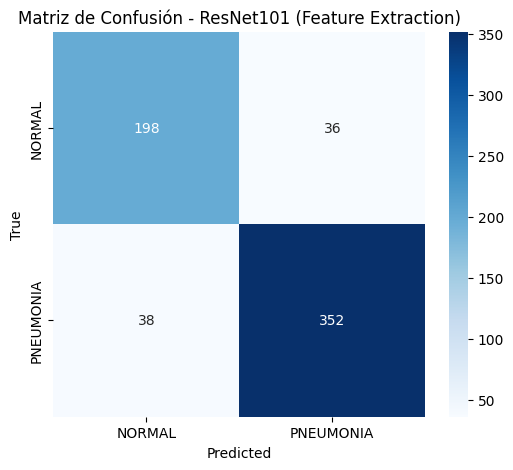


Métricas de Clasificación - ResNet101 (Feature Extraction)
              precision    recall  f1-score   support

      NORMAL       0.84      0.85      0.84       234
   PNEUMONIA       0.91      0.90      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624

AUC-ROC: 0.9455
Especificidad: 0.8462


In [26]:
# Elegimos la semilla para ver las métricas de esa ejecución
y_true, y_pred, y_pred_probs = evaluar_modelo(models_resnet_ft[2], test_generator, nombre_modelo="ResNet101 (Feature Extraction)")

#### **Matriz de Confusión:**
* #### Clasifica correctamente la mayoría de los casos de PNEUMONIA: 352 sobre 390.
* #### También se clasifican adecuadamente la mayoría de las imágenes NORMALES: 198 aciertos sobre 234.

#### **Métricas de Clasificación:**

#### **1. Precisión**

* #### NORMAL → 0.84. El 84% de las veces que el modelo predice que es normal, acierta.
* #### PNEUMONIA → 0.91. El 91% de las veces que predice neumonía, acierta.

#### **2. Recall (Sensibilidad)**

* #### NORMAL → 0.85. El modelo detecta correctamente el 85% de las imágenes normales.
* #### PNEUMONIA →  0.90. El modelo identifica correctamente el 90% de los casos con neumonía, lo cual es un resultado sólido para diagnóstico médico.

#### **3. F1-Score**
 * #### Buen equilibrio entre precisión y sensibilidad, destacando la clase neumonía (0.90), lo que refuerza su utilidad diagnóstica.

#### **4. Accuracy**
* #### Precisión global del modelo: 0.88. Es un valor alto y consistente. Dado que el dataset está balanceado, esta métrica es representativa.

#### **AUC-ROC (0.9455):** Indica excelente capacidad del modelo para distinguir entre ambas clases. Cuanto más cerca de 1, mejor.

#### **Especificidad (0.8462):** Mide la capacidad del modelo para identificar correctamente los casos normales. Este valor, aunque algo inferior al recall de la clase neumonía, muestra un buen equilibrio, lo que sugiere que el modelo no presenta un sesgo acusado hacia ninguna de las dos clases.